# Football Events and Game Information

imports and initialization

In [1]:
import zipfile
%matplotlib inline 
import numpy as np 
import scipy as sp 
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import pandas as pd 
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use(['dark_background', 'bmh'])
plt.rc('axes', facecolor='k')
plt.rc('figure', facecolor='k')
plt.rc('figure', figsize=(5,5))

## Exploring the data

In [3]:
df_events = pd.read_csv("Data/events.csv")
df_game_info = pd.read_csv("Data/ginf.csv")

In [4]:
# understand the values of some columns in events df
encoding = pd.read_table('Data/dictionary.txt', delim_whitespace=False, names=('num','events'))
event_type=encoding[1:13]
event_type_2=encoding[14:18]
side=encoding[19:21]
shot_place=encoding[22:35]
shot_outcome=encoding[36:40]
location=encoding[41:60]
bodypart=encoding[61:64]
assist_method=encoding[65:70]
situition=encoding[71:75]

In [5]:
assist_method

,num,events
65,0,None
66,1,Pass
67,2,Cross
68,3,Headed pass
69,4,Through ball


In [6]:
# manually convert the dictionary.txt to python dicts
event_types = {1:'Attempt', 2:'Corner', 3:'Foul', 4:'Yellow card', 5:'Second yellow card', 6:'Red card', 7:'Substitution', 8:'Free kick won', 9:'Offside', 10:'Hand ball', 11:'Penalty conceded'}
event_types2 = {12:'Key Pass', 13:'Failed through ball', 14:'Sending off', 15:'Own goal'}
sides = {1:'Home', 2:'Away'}
shot_places = {1:'Bit too high', 2:'Blocked', 3:'Bottom left corner', 4:'Bottom right corner', 5:'Centre of the goal', 6:'High and wide', 7:'Hits the bar', 8:'Misses to the left', 9:'Misses to the right', 10:'Too high', 11:'Top centre of the goal', 12:'Top left corner', 13:'Top right corner'}
shot_outcomes = {1:'On target', 2:'Off target', 3:'Blocked', 4:'Hit the bar'}
locations = {1:'Attacking half', 2:'Defensive half', 3:'Centre of the box', 4:'Left wing', 5:'Right wing', 6:'Difficult angle and long range', 7:'Difficult angle on the left', 8:'Difficult angle on the right', 9:'Left side of the box', 10:'Left side of the six yard box', 11:'Right side of the box', 12:'Right side of the six yard box', 13:'Very close range', 14:'Penalty spot', 15:'Outside the box', 16:'Long range', 17:'More than 35 yards', 18:'More than 40 yards', 19:'Not recorded'}
bodyparts = {1:'right foot', 2:'left foot', 3:'head'}
assist_methods = {0:np.nan, 1:'Pass', 2:'Cross', 3:'Headed pass', 4:'Through ball'}
situations = {1:'Open play', 2:'Set piece', 3:'Corner', 4:'Free kick'}

In [7]:
# Mapping the dicts onto the events dataframe
df_events['event_type'] =   df_events['event_type'].map(event_types)
df_events['event_type2'] =  df_events['event_type2'].map(event_types2)
df_events['side'] =         df_events['side'].map(sides)
df_events['shot_place'] =   df_events['shot_place'].map(shot_places)
df_events['shot_outcome']=  df_events['shot_outcome'].map(shot_outcomes)
df_events['location'] =     df_events['location'].map(locations)
df_events['bodypart'] =     df_events['bodypart'].map(bodyparts)
df_events['assist_method']= df_events['assist_method'].map(assist_methods)
df_events['situation'] =    df_events['situation'].map(situations)

In [8]:
## Naming the leagues with their popular names, which will make thinks much clear for us
leagues = {'E0': 'Premier League', 'SP1': 'La Liga',
          'I1': 'Serie A', 'F1': 'League One', 'D1': 'Bundesliga'}

## Map them to events
df_game_info.league = df_game_info.league.map(leagues)

In [9]:
df_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10112 entries, 0 to 10111
Data columns (total 18 columns):
id_odsp      10112 non-null object
link_odsp    10112 non-null object
adv_stats    10112 non-null bool
date         10112 non-null object
league       10112 non-null object
season       10112 non-null int64
country      10112 non-null object
ht           10112 non-null object
at           10112 non-null object
fthg         10112 non-null int64
ftag         10112 non-null int64
odd_h        10112 non-null float64
odd_d        10112 non-null float64
odd_a        10112 non-null float64
odd_over     977 non-null float64
odd_under    977 non-null float64
odd_bts      977 non-null float64
odd_bts_n    977 non-null float64
dtypes: bool(1), float64(7), int64(3), object(7)
memory usage: 1.3+ MB


# Idea: Predict Missing odds with Regression

In [10]:
df_game_info.season = df_game_info.season.astype('category')
df_game_info.league = df_game_info.league.astype('category')
df_game_info.country = df_game_info.country.astype('category')

In [11]:
df_game_info.league.unique()

[Bundesliga, League One, Premier League, La Liga, Serie A]
Categories (5, object): [Bundesliga, League One, Premier League, La Liga, Serie A]

In [12]:
# df_game_info.info()

# Data Pre-processing

## Make it in One Table

In [13]:
# Merge other dataset to have country, league, date and season
df_events = df_events.merge(df_game_info ,how = 'left')

## Handling Missing Values

In [14]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [15]:
# # Drop all the null values (remove 70% of the data)
# data_df.dropna(inplace=True)
# data_df.info()

In [16]:
missing_values_table(df_events)

Your selected dataframe has 39 columns.
There are 15 columns that have missing values.


,Missing Values,% of Total Values
player_in,889294,94.5
player_out,889271,94.5
odd_over,842329,89.5
odd_under,842329,89.5
odd_bts,842329,89.5
odd_bts_n,842329,89.5
assist_method,773104,82.2
event_type2,726716,77.2
shot_place,713550,75.8
shot_outcome,712511,75.7


In [17]:
# Fill the required features with new class 'unknown'
df_events.shot_place.fillna('UNK', inplace= True)
df_events.player.fillna('UNK', inplace= True)
df_events.shot_outcome.fillna('UNK', inplace= True)
df_events.bodypart.fillna('UNK', inplace= True)
df_events.location.fillna('UNK', inplace= True)
df_events.assist_method.fillna('UNK', inplace= True);

In [18]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941009 entries, 0 to 941008
Data columns (total 39 columns):
id_odsp          941009 non-null object
id_event         941009 non-null object
sort_order       941009 non-null int64
time             941009 non-null int64
text             941009 non-null object
event_type       941009 non-null object
event_type2      214293 non-null object
side             941009 non-null object
event_team       941009 non-null object
opponent         941009 non-null object
player           941009 non-null object
player2          291310 non-null object
player_in        51715 non-null object
player_out       51738 non-null object
shot_place       941009 non-null object
shot_outcome     941009 non-null object
is_goal          941009 non-null int64
location         941009 non-null object
bodypart         941009 non-null object
assist_method    941009 non-null object
situation        229137 non-null object
fast_break       941009 non-null int64
link_odsp      

In [19]:
# Notice that a lot of the floats and ints are in fact categoricals
# We can fix this with Pandas' astype function
categoricals = ['id_odsp', 'event_type', 'event_team', 'opponent', 'shot_place', 'shot_outcome', 'location', 'bodypart', 'assist_method', 'situation', 'side']
d = dict.fromkeys(categoricals,'category')
df_events = df_events.astype(d)
df_events['is_goal'] = df_events['is_goal'].astype('bool') # this is a bool, we can fix that too while we're at it

In [20]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941009 entries, 0 to 941008
Data columns (total 39 columns):
id_odsp          941009 non-null category
id_event         941009 non-null object
sort_order       941009 non-null int64
time             941009 non-null int64
text             941009 non-null object
event_type       941009 non-null category
event_type2      214293 non-null object
side             941009 non-null category
event_team       941009 non-null category
opponent         941009 non-null category
player           941009 non-null object
player2          291310 non-null object
player_in        51715 non-null object
player_out       51738 non-null object
shot_place       941009 non-null category
shot_outcome     941009 non-null category
is_goal          941009 non-null bool
location         941009 non-null category
bodypart         941009 non-null category
assist_method    941009 non-null category
situation        229137 non-null category
fast_break       941009 non-null 

# Question #1 to answer
What is the value of a shot? Or what is the probability of a shot being a goal given its location, shooter, league, assist method, gamestate, number of players on the pitch, time - known as expected goals (xG) models [Binary classification, Sara ]


In [21]:
# manually chosen features
feat_cols = ['odd_h', 'odd_d', 'odd_a', 'assist_method', 'location', 'side', 'event_team', 'shot_place', 'shot_outcome', 'bodypart', 'is_goal']
df_data = df_events[feat_cols]

In [22]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941009 entries, 0 to 941008
Data columns (total 11 columns):
odd_h            941009 non-null float64
odd_d            941009 non-null float64
odd_a            941009 non-null float64
assist_method    941009 non-null category
location         941009 non-null category
side             941009 non-null category
event_team       941009 non-null category
shot_place       941009 non-null category
shot_outcome     941009 non-null category
bodypart         941009 non-null category
is_goal          941009 non-null bool
dtypes: bool(1), category(7), float64(3)
memory usage: 36.8 MB


In [23]:
missing_values_table(df_data)

Your selected dataframe has 11 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## Handling imbalance classes

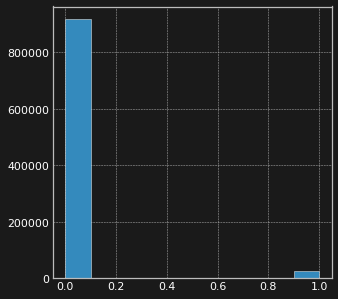

In [24]:
# distribution of the response variable
df_data.is_goal.astype('int').hist();

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
training_features = df_data.drop(columns=['is_goal'])
training_target = df_data.is_goal

we have class imbalance, we will use evaluation metrics different from accuracy which include (True positive, True negative, False positive, False negative)

In [27]:
# One-hot encoding for categorical columns
df_feats_dumm = pd.get_dummies(training_features)

In [28]:
df_feats_dumm.head()

,odd_h,odd_d,odd_a,assist_method_Cross,assist_method_Headed pass,assist_method_Pass,assist_method_Through ball,assist_method_UNK,location_Attacking half,location_Centre of the box,location_Defensive half,location_Difficult angle and long range,location_Difficult angle on the left,location_Difficult angle on the right,location_Left side of the box,location_Left side of the six yard box,location_Left wing,location_Long range,location_More than 35 yards,location_More than 40 yards,location_Not recorded,location_Outside the box,location_Penalty spot,location_Right side of the box,location_Right side of the six yard box,location_Right wing,location_UNK,location_Very close range,side_Away,side_Home,event_team_AC Ajaccio,event_team_AC Milan,event_team_AJ Auxerre,event_team_AS Monaco,event_team_AS Nancy Lorraine,event_team_AS Roma,event_team_Alaves,event_team_Almeria,event_team_Angers,event_team_Arsenal,event_team_Aston Villa,event_team_Atalanta,event_team_Athletic Bilbao,event_team_Atletico Madrid,event_team_Barcelona,event_team_Bastia,event_team_Bayer Leverkusen,event_team_Bayern Munich,event_team_Bologna,event_team_Bordeaux,...,event_team_Sochaux,event_team_Southampton,event_team_SpVgg Greuther Furth,event_team_Sporting Gijon,event_team_St Etienne,event_team_Stade Rennes,event_team_Stade de Reims,event_team_Stoke City,event_team_Sunderland,event_team_Swansea,event_team_TSG Hoffenheim,event_team_TSV Eintracht Braunschweig,event_team_Torino,event_team_Tottenham,event_team_Toulouse,event_team_Troyes,event_team_US Pescara,event_team_Udinese,event_team_Valencia,event_team_Valenciennes,event_team_VfB Stuttgart,event_team_VfL Wolfsburg,event_team_Villarreal,event_team_Watford,event_team_Werder Bremen,event_team_West Brom,event_team_West Ham,shot_place_Bit too high,shot_place_Blocked,shot_place_Bottom left corner,shot_place_Bottom right corner,shot_place_Centre of the goal,shot_place_High and wide,shot_place_Hits the bar,shot_place_Misses to the left,shot_place_Misses to the right,shot_place_Too high,shot_place_Top centre of the goal,shot_place_Top left corner,shot_place_Top right corner,shot_place_UNK,shot_outcome_Blocked,shot_outcome_Hit the bar,shot_outcome_Off target,shot_outcome_On target,shot_outcome_UNK,bodypart_UNK,bodypart_head,bodypart_left foot,bodypart_right foot
0,1.56,4.41,7.42,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,1.56,4.41,7.42,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0
2,1.56,4.41,7.42,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0
3,1.56,4.41,7.42,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0
4,1.56,4.41,7.42,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0


In [29]:
x_train, x_val, y_train, y_val = train_test_split(df_feats_dumm, training_target,
                                                  test_size = .1,
                                                  random_state=12)


In [30]:
x_train.shape

(846908, 195)

In [31]:
x_val.shape

(94101, 195)

In [32]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [33]:
print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({False: 824932, True: 21976})


In [34]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(x_train, y_train)

In [35]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({False: 21976, True: 21976})


## Logistic Regression model

In [36]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_res, y_res)
print(model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [37]:
# make predictions
expected = y_res
predicted = model.predict(X_res)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

              precision    recall  f1-score   support

       False       1.00      0.95      0.97     21976
        True       0.95      1.00      0.97     21976

   micro avg       0.97      0.97      0.97     43952
   macro avg       0.97      0.97      0.97     43952
weighted avg       0.97      0.97      0.97     43952

[[20834  1142]
 [   22 21954]]


In [38]:
# make predictions
expected = y_val
predicted = model.predict(x_val)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

              precision    recall  f1-score   support

       False       1.00      0.95      0.97     91631
        True       0.34      1.00      0.51      2470

   micro avg       0.95      0.95      0.95     94101
   macro avg       0.67      0.97      0.74     94101
weighted avg       0.98      0.95      0.96     94101

[[86861  4770]
 [    5  2465]]


In [39]:
metrics.accuracy_score(expected, predicted)

0.9492566497699281

In [40]:
metrics.balanced_accuracy_score(expected, predicted)

0.9729595450543429

## Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 12, verbose = 1, n_jobs = -1)

In [42]:
# Train on the training data
random_forest.fit(X_res, y_res)

# Feature names
features = list(df_feats_dumm.columns)


# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict(x_val)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


In [43]:
metrics.accuracy_score(y_val, predictions)

0.9515201751309763

In [44]:
metrics.balanced_accuracy_score(y_val, predictions)

0.973530898021403

In [45]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

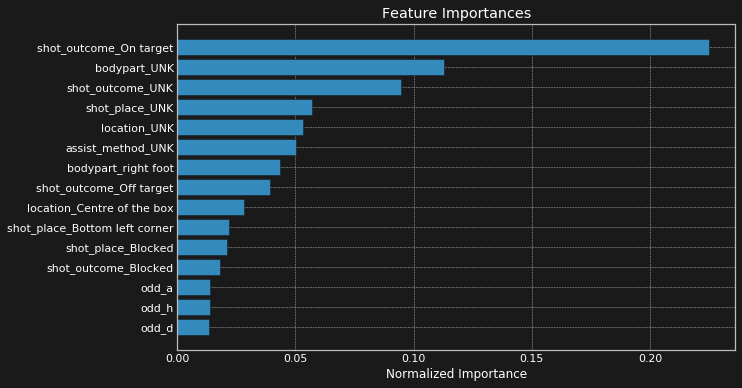

In [46]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

## Without handling class imbalance

In [47]:
training_features = df_data.drop(columns=['is_goal'])
training_target = df_data.is_goal

In [48]:
x_train, x_val, y_train, y_val = train_test_split(df_feats_dumm, training_target,
                                                  test_size = .1,
                                                  random_state=12)


In [49]:
model = LogisticRegression()
model.fit(x_train, y_train)
print(model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [50]:
# make predictions
expected = y_val
predicted = model.predict(x_val)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99     91631
        True       0.71      0.58      0.64      2470

   micro avg       0.98      0.98      0.98     94101
   macro avg       0.85      0.79      0.82     94101
weighted avg       0.98      0.98      0.98     94101

[[91036   595]
 [ 1027  1443]]


In [51]:
metrics.accuracy_score(expected, predicted)
# 
# metrics.roc_auc_score(expected, predicted)

0.9827632012412195

In [52]:
metrics.balanced_accuracy_score(expected, predicted)

0.7888585453440544

# Data Analysis and Visualisations

In which leagues is the referee more likely to give a card? 

Find a relationship between receiving cards in the first half and performance in the second half.

Cards given depending on body-parts



In [53]:
df_unique_events = df_events.drop_duplicates() 

In [54]:
# Get the yellow cards data

first_yellow_cards = df_unique_events [df_unique_events ['event_type'] == ('Yellow card')] # select first yellow cards
second_yellow_cards= df_unique_events [df_unique_events ['event_type'] == ('Second yellow card')] # select second yellow cards
red_cards = df_unique_events [df_unique_events['event_type'] == ('Red card')] # select red cards
yellow_cards= df_unique_events [df_unique_events ['event_type'] == ('Yellow card' or 'Second yellow card')]

card_frames = [red_cards, yellow_cards]
all_cards = pd.concat(card_frames)


Text(0.5, 1.0, 'When Red Cards Occur')

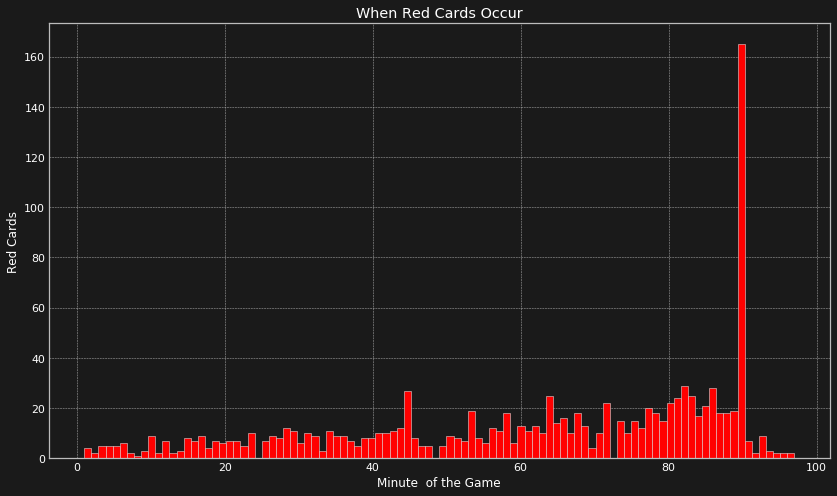

In [55]:
# Get the yellow cards against time of playing the game
fig = plt.figure(figsize=(14,8))
plt.hist(red_cards.time, 100, color="red")
plt.xlabel("Minute  of the Game")
plt.ylabel("Red Cards")
plt.title("When Red Cards Occur")



Text(0.5, 1.0, 'When First Yellow Cards Occur')

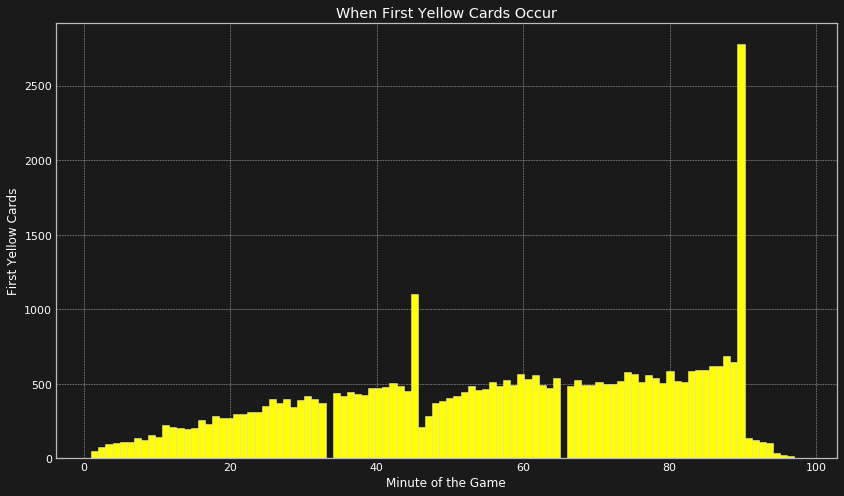

In [56]:
# plot the second yellow cards against time of playing the game

fig2 = plt.figure(figsize=(14,8))
plt.hist(first_yellow_cards.time, 100, color="yellow")
plt.xlabel("Minute of the Game")
plt.ylabel("First Yellow Cards")
plt.title("When First Yellow Cards Occur")



Text(0.5, 1.0, 'When Second Yellow Cards Occur')

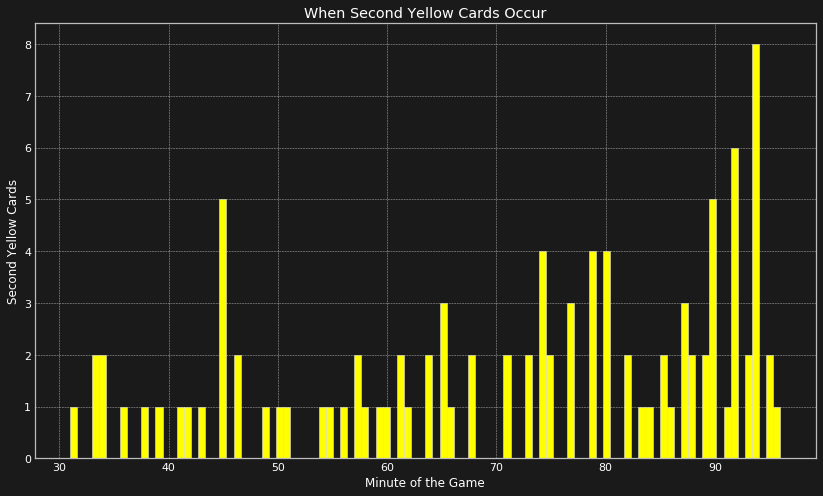

In [57]:
# plot the red cards against time of playing the game

fig3 = plt.figure(figsize=(14,8))
plt.hist(second_yellow_cards.time, 100, color="yellow")
plt.xlabel("Minute of the Game")
plt.ylabel("Second Yellow Cards")
plt.title("When Second Yellow Cards Occur")



Text(0.5, 1.0, 'When cards are served')

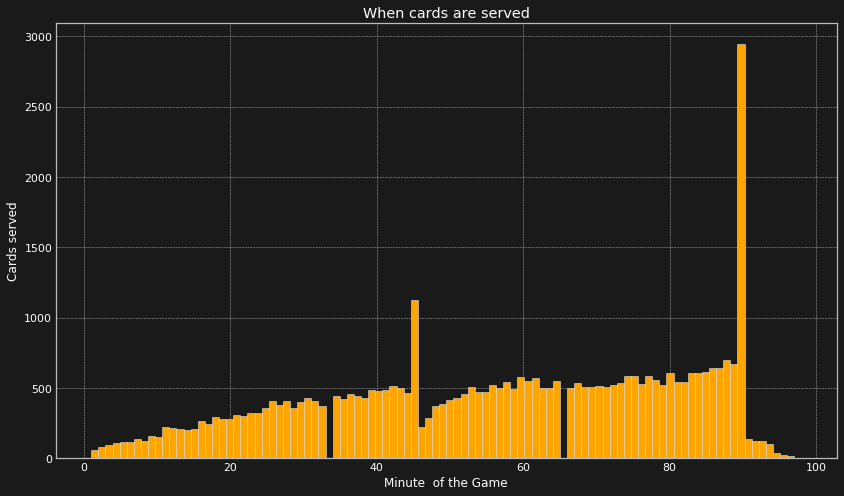

In [58]:
# Get the yellow cards against time of playing the game
fig4 = plt.figure(figsize=(14,8))                                                            
plt.hist(all_cards.time, 100, color="orange")
plt.xlabel("Minute  of the Game")
plt.ylabel("Cards served")
plt.title("When cards are served")


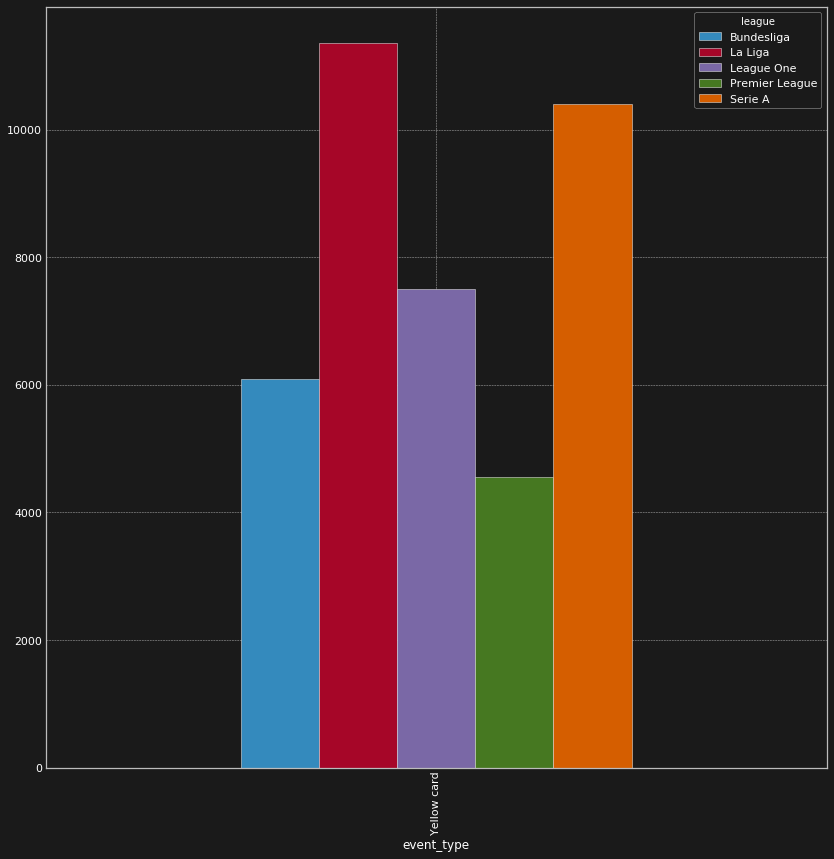

In [59]:
yellow_league = pd.crosstab(index=yellow_cards.event_type, columns=yellow_cards.league)
yellow_league.plot(kind='bar', figsize=(14,14))


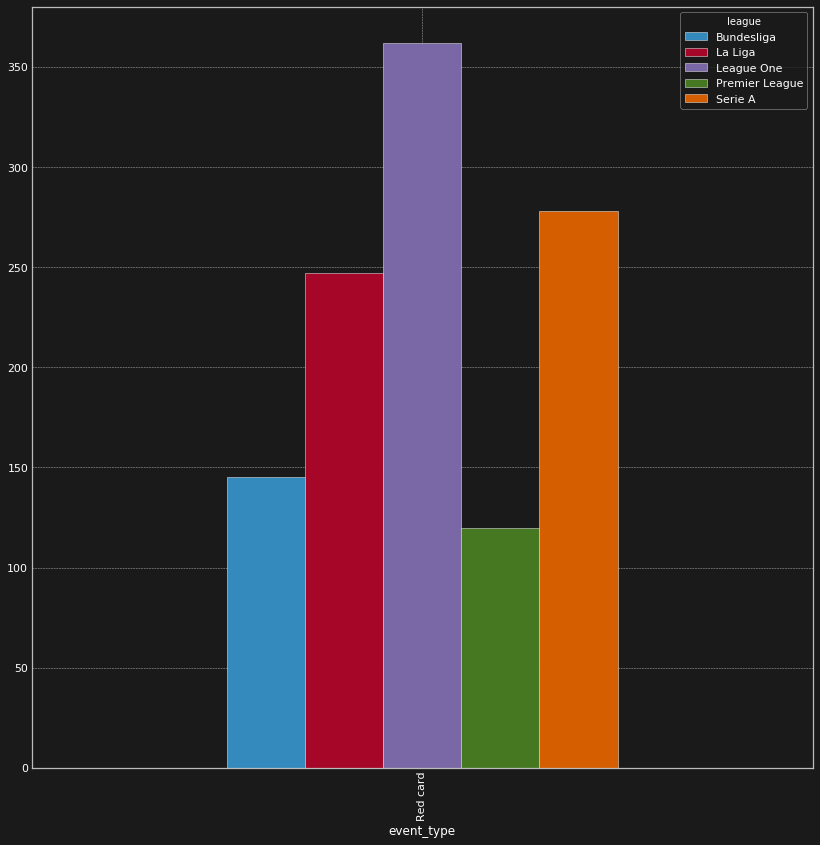

In [60]:
red_league = pd.crosstab(index=red_cards.event_type, columns=red_cards.league)
red_league .plot(kind='bar', figsize=(14,14))

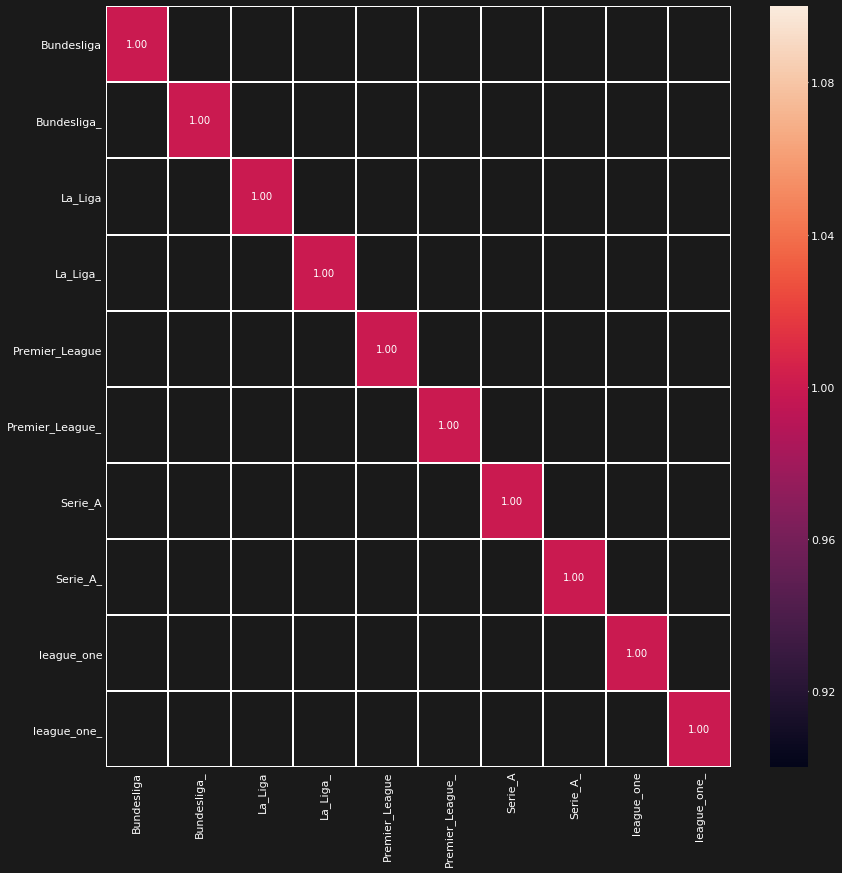

In [61]:
player_red_card = (red_cards[['player', 'league']])
league_one = player_red_card [player_red_card.league == 'League One'].groupby('player').count()
La_Liga = player_red_card [player_red_card.league == 'La Liga'].groupby('player').count()
Bundesliga = player_red_card [player_red_card.league == 'Bundesliga'].groupby('player').count()
Serie_A = player_red_card [player_red_card.league == 'Serie A'].groupby('player').count()
Premier_League = player_red_card [player_red_card.league == 'Premier League'].groupby('player').count()


player_red_card_ = (yellow_cards[['player', 'league']])
league_one_ = player_red_card [player_red_card.league == 'League One'].groupby('player').count()
La_Liga_ = player_red_card [player_red_card.league == 'La Liga'].groupby('player').count()
Bundesliga_ = player_red_card [player_red_card.league == 'Bundesliga'].groupby('player').count()
Serie_A_ = player_red_card [player_red_card.league == 'Serie A'].groupby('player').count()
Premier_League_ = player_red_card [player_red_card.league == 'Premier League'].groupby('player').count()

league_one.columns=['league_one']
La_Liga.columns=['La_Liga']
Bundesliga.columns=['Bundesliga']
Serie_A.columns=['Serie_A']
Premier_League.columns=['Premier_League']

league_one_.columns=['league_one_']
La_Liga_.columns=['La_Liga_']
Bundesliga_.columns=['Bundesliga_']
Serie_A_.columns=['Serie_A_']
Premier_League_.columns=['Premier_League_']

red_cards_per_league = pd.concat([league_one, La_Liga, Bundesliga, Serie_A,  Premier_League, league_one_, La_Liga_, Bundesliga_, Serie_A_,  Premier_League_])
red_cards_per_league.fillna(0)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(red_cards_per_league.corr(), linewidths=1, annot=True, fmt=".2f")


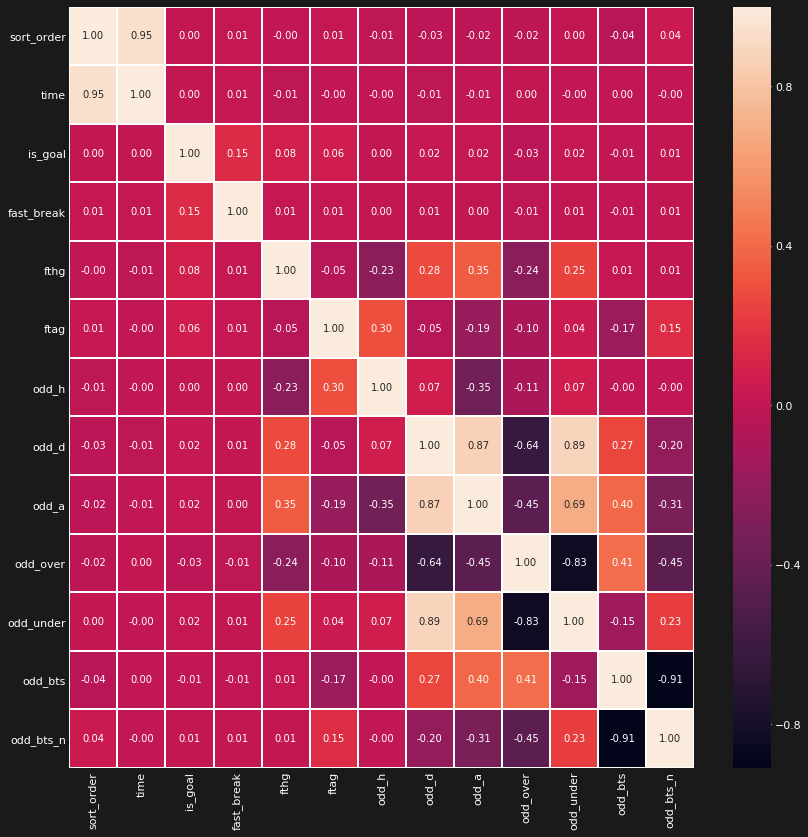

In [62]:


f, ax = plt.subplots(figsize=(14, 14))

df2 = df_unique_events.drop(['adv_stats'], axis=1)
sns.heatmap(df2.corr(), linewidths=1, annot=True, fmt=".2f")

Text(0.5, 1.0, 'Number of goals against Time during match')

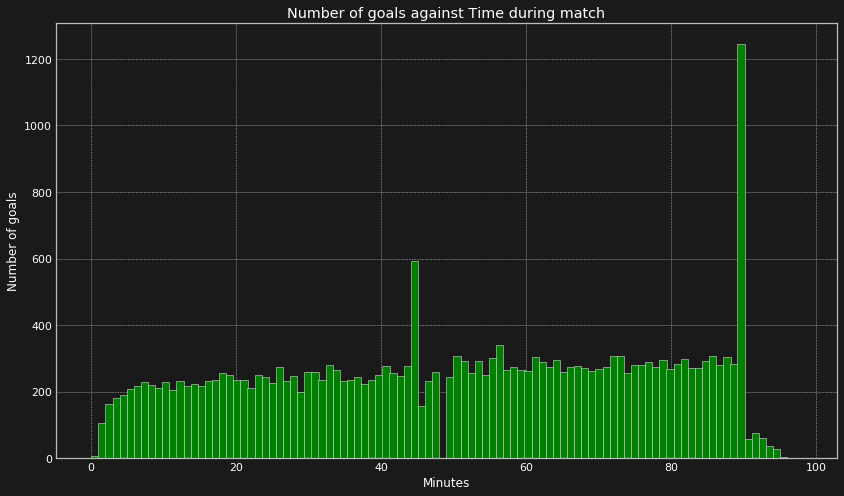

In [63]:
goals=df_unique_events[df_unique_events["is_goal"]==1]

fig4=plt.figure(figsize=(14,8))
plt.hist(goals.time,width=1,bins=100,color="green")   #100 so 1 bar per minute
plt.xlabel("Minutes")
plt.ylabel("Number of goals")
plt.title("Number of goals against Time during match")

In [64]:
no_goal=df_unique_events[df_unique_events["is_goal"]==0]
goal=df_unique_events[df_unique_events["is_goal"]==1]

goals=pd.concat([no_goal, goal])

player_no_goal = no_goal[['player','is_goal']]
player_no_goals = player_no_goal.groupby('player').count()

player_no_goals.columns = ['goal_False']

player_goal = goal[['player','is_goal']]
player_goals = player_goal.groupby('player').count()
player_goals.columns = ['goal_True']

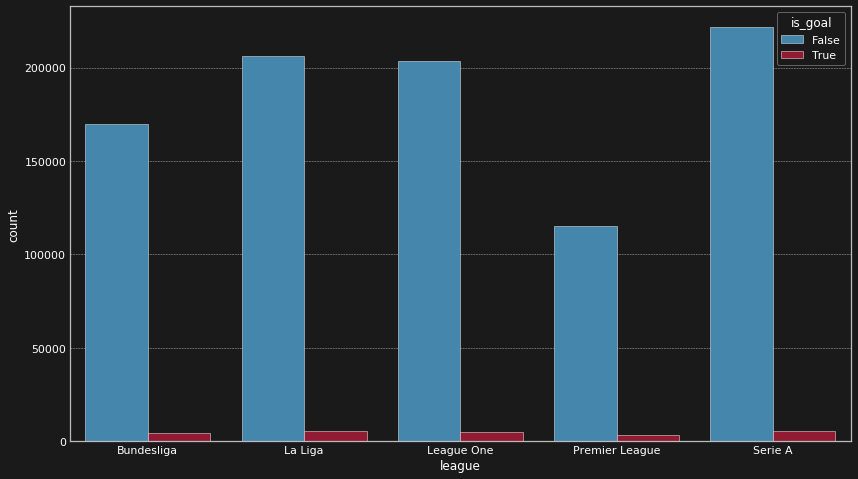

In [65]:
plt.figure(figsize=(14,8))
sns.countplot(x='league', hue='is_goal', data=goals)

In [66]:
cross = pd.crosstab(index=goals.league, columns=goals.is_goal)

In [67]:
cross

is_goal,False,True
league,,
Bundesliga,169952,4621
La Liga,206360,5583
League One,203247,5199
Premier League,115368,3552
Serie A,221636,5491


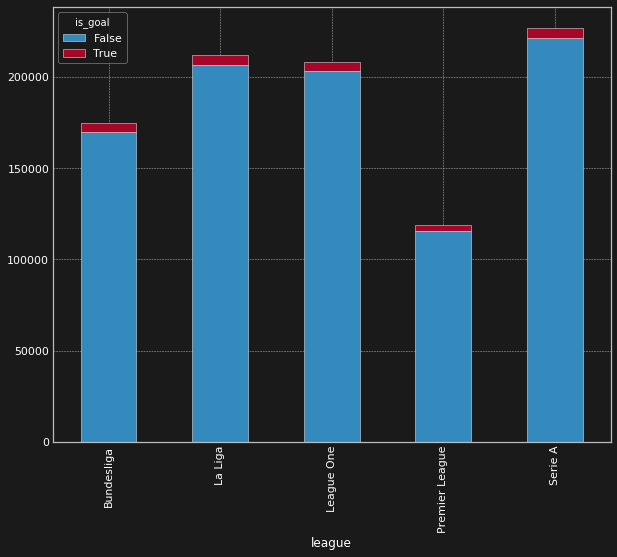

In [68]:
cross.plot(kind='bar', stacked=True, figsize=(10,8))

In [69]:
import venn
AA = goals.player.groupby(goals.league)
names = list(AA.groups.keys())
labels = venn.get_labels([set(AA.get_group(names[i])) for i in range(5)], fill=['number', 'logic'])

In [70]:
labels

{'00001': '00001: 1150 ',
 '00010': '00010: 673 ',
 '00011': '00011: 61 ',
 '00100': '00100: 1326 ',
 '00101': '00101: 62 ',
 '00110': '00110: 69 ',
 '00111': '00111: 11 ',
 '01000': '01000: 1356 ',
 '01001': '01001: 124 ',
 '01010': '01010: 71 ',
 '01011': '01011: 19 ',
 '01100': '01100: 74 ',
 '01101': '01101: 7 ',
 '01110': '01110: 12 ',
 '01111': '01111: 1 ',
 '10000': '10000: 888 ',
 '10001': '10001: 36 ',
 '10010': '10010: 49 ',
 '10011': '10011: 8 ',
 '10100': '10100: 38 ',
 '10101': '10101: 4 ',
 '10110': '10110: 2 ',
 '10111': '10111: 0 ',
 '11000': '11000: 62 ',
 '11001': '11001: 6 ',
 '11010': '11010: 6 ',
 '11011': '11011: 1 ',
 '11100': '11100: 2 ',
 '11101': '11101: 0 ',
 '11110': '11110: 0 ',
 '11111': '11111: 1 '}

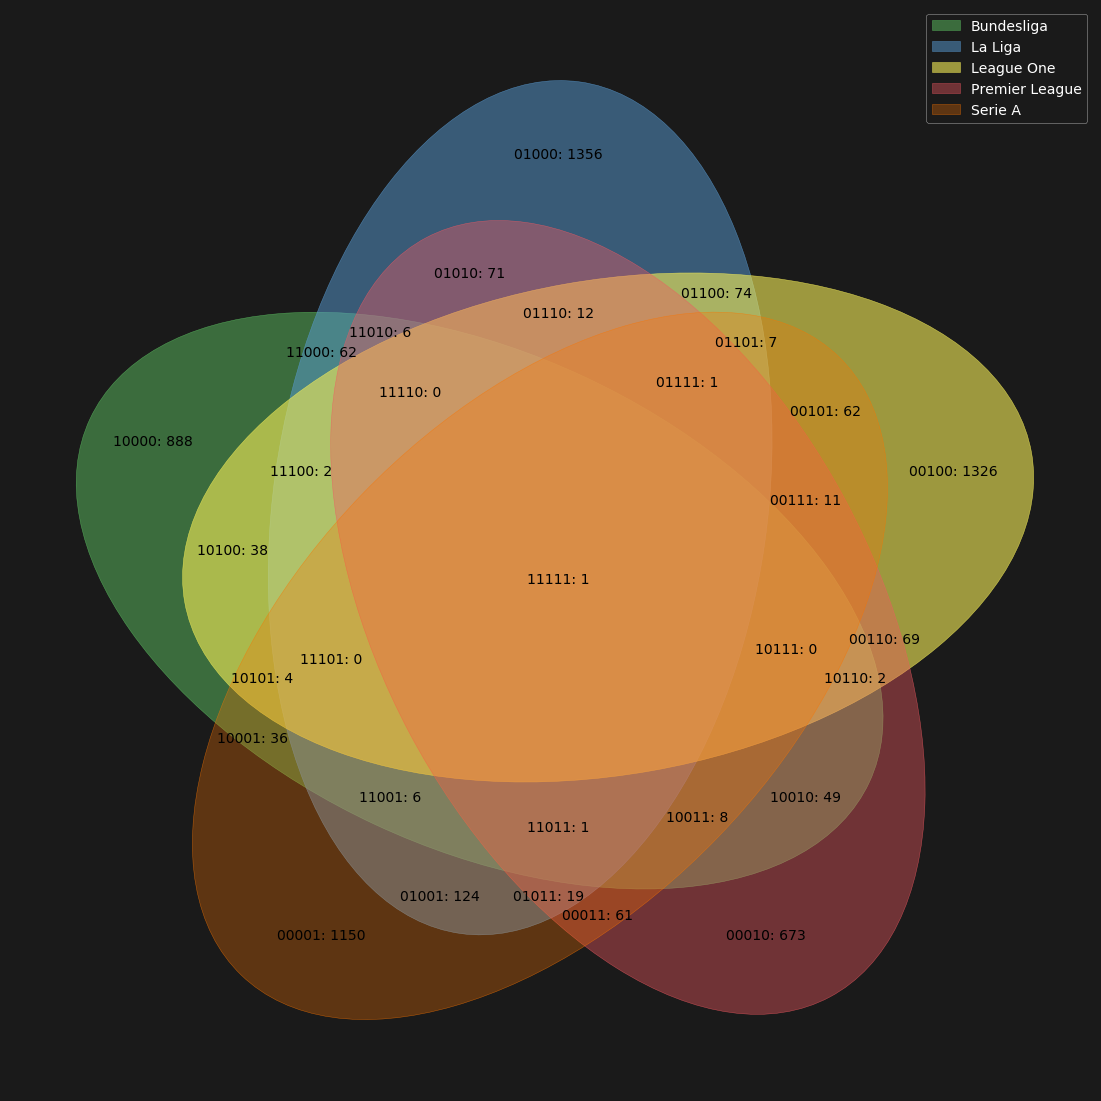

In [71]:
fig, ax = venn.venn5(labels, names=names, figsize=(20,20), fontsize=14)
fig.show()

In [72]:
#sns.barplot(x=goals.league, hue=goals.is_goal, data=goals)

In [73]:
joined = pd.concat([player_goals, player_no_goals], axis=1)


joined.columns = ['goal_True', 'goal_False'];
joined.fillna(0) 



,goal_True,goal_False
UNK,5.0,60995.0
aara³n,0.0,2.0
aaron,1.0,145.0
aaron cresswell,4.0,239.0
aaron hughes,1.0,20.0
aaron hunt,25.0,558.0
aaron lennon,8.0,177.0
aaron leya iseka,0.0,17.0
aaron martin,0.0,41.0
aaron ramsey,17.0,406.0
